# System Threat Forecaster

## **Introduction**
This notebook focuses on predicting system threats using machine learning techniques. We will perform:
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Model Training & Evaluation
- Model Comparison & Optimization

The goal of this competition is to predict a system’s probability of getting infected by various families of malware, based on different properties of that system. The telemetry data containing these properties and the system infections was generated by threat reports collected by system's antivirus software.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv



# Exploratory Data Analysis (EDA)

## **Purpose of EDA**
Exploratory Data Analysis (EDA) is a crucial step in the data science pipeline. It helps in understanding the dataset, identifying patterns, detecting anomalies, and forming hypotheses for feature engineering and model selection.

## **Key Steps in EDA**
1. **Data Overview**  
   - Checking the number of rows and columns.  
   - Displaying the first few records using `df.head()`.  

2. **Handling Missing Values**  
   - Identifying missing values using `df.isnull().sum()`.  
   - Imputing missing values or dropping columns if necessary.  

3. **Summary Statistics**  
   - Using `df.describe()` to analyze central tendencies and dispersion.  
   - Checking categorical and numerical feature distributions.  

4. **Data Distributions and Outliers**  
   - Histograms, box plots, and violin plots for numerical features.  
   
Before training our models, we analyze the dataset to understand patterns, distributions, and potential missing values.



In [2]:


df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")
sample_submission = pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')
df.head()


,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [4]:
df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


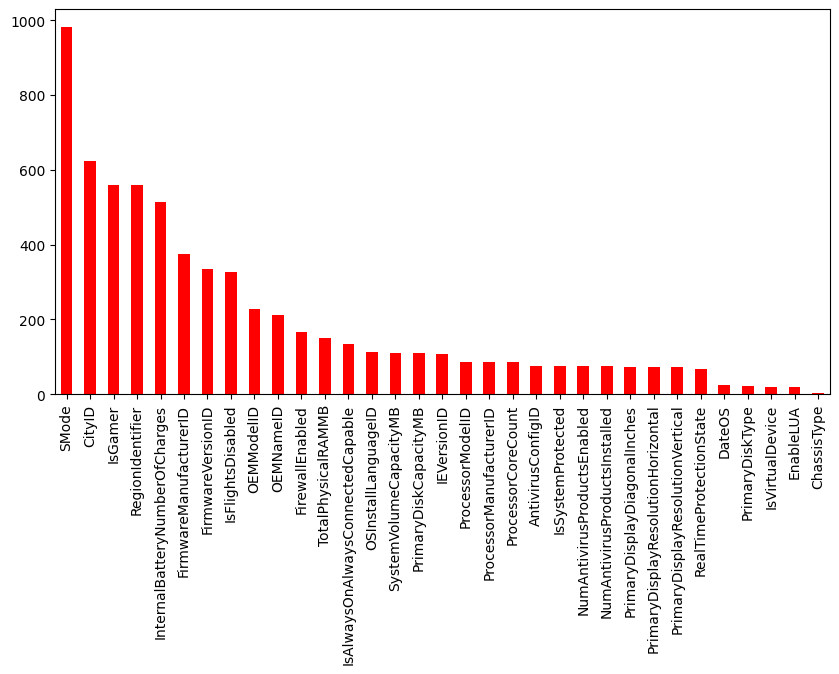

In [5]:
import matplotlib.pyplot as plt
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values.plot(kind='bar', figsize=(10, 5), color='red')
plt.show()


In [6]:
from sklearn.impute import SimpleImputer

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = num_cols.drop('target', errors='ignore')

# Impute numerical columns with mean
imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])
test_data[num_cols] = imputer_num.transform(test_data[num_cols])

# Impute categorical columns with most frequent value
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
test_data[cat_cols] = imputer_cat.transform(test_data[cat_cols])

print("Missing values handled successfully!")

Missing values handled successfully!


In [7]:
df.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,...,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,0.505250
std,0.0,1.014831,0.131566,13798.075222,0.520484,0.155232,0.056654,63.062151,48791.326700,89.188929,...,220.902416,21116.617137,0.499984,0.061849,0.334614,0.197316,0.234339,0.455513,4.549763,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,...,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36825.000000,89.000000,...,142.000000,13154.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,...,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122547.000000,267.000000,...,556.000000,52319.250000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000
max,0.0,8.000000,1.000000,70490.000000,5.000000,4.000000,1.000000,222.000000,167957.000000,296.000000,...,1083.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


In [8]:
# Calculate the number of unique values in each column and sort in descending order
cardinality = df.nunique().sort_values(ascending=False)
# Identify columns with only one unique value (low cardinality)
low_cardinality = cardinality[cardinality == 1].index.tolist()
# Drop low-cardinality columns from the training dataset
df = df.drop(columns=low_cardinality)
# Drop the same low-cardinality columns from the test dataset to maintain consistency
test_data = test_data.drop(columns=low_cardinality)
# Display the new shape of the DataFrame after dropping columns
df.shape

(100000, 73)

In [9]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
# Identify categorical features with low cardinality (≤10 unique values)
selected_features = [col for col in categorical_cols if df[col].nunique() <= 10]
# Identify categorical features with high cardinality (>10 unique values)
high_cardinality_features = [col for col in categorical_cols if df[col].nunique() > 10]
# Apply one-hot encoding to low-cardinality categorical features (drop_first=True avoids dummy variable trap)
df = pd.get_dummies(df, columns=selected_features, drop_first=True)
test_data= pd.get_dummies(test_data, columns=selected_features, drop_first=True)
# Display the updated DataFrame
df

,MachineID,EngineVersion,AppVersion,SignatureVersion,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,...,LicenseActivationChannel_Retail,LicenseActivationChannel_Retail:TB:Eval,LicenseActivationChannel_Volume:GVLK,LicenseActivationChannel_Volume:MAK,FlightRing_NOT_SET,FlightRing_RP,FlightRing_Retail,FlightRing_Unknown,FlightRing_WIF,FlightRing_WIS
0,f541bae429089117c4aac39c90dd3416,1.1.15200.1,4.18.1807.18075,1.275.1003.0,7.0,0.0,53447.0,1.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
1,dc2b14d9ce3a0ce4050bb640190f2ca5,1.1.15100.1,4.18.1807.18075,1.273.1465.0,7.0,0.0,53447.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,1.1.15200.1,4.18.1807.18075,1.275.1546.0,7.0,0.0,53447.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
3,38711eae85eb77a72ec5dfdf27eb2a76,1.1.15200.1,4.12.17007.18011,1.275.1141.0,7.0,0.0,46413.0,2.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
4,32607c9a543a9214e2c7e45800ed4849,1.1.15200.1,4.13.17134.228,1.275.1283.0,7.0,0.0,40466.0,2.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,a378b2196a7a1d8ee0d4f989ee46730e,1.1.15200.1,4.18.1807.18075,1.275.1582.0,7.0,0.0,68585.0,2.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
99996,7f4433ca05d24b9bbdd3932f8b05e61f,1.1.15100.1,4.18.1806.18062,1.273.1156.0,7.0,0.0,11280.0,2.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
99997,d6852dfff534e03d5ddfd3c7875ab072,1.1.15200.1,4.18.1807.18075,1.275.209.0,7.0,0.0,53447.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
99998,70a8dc682128c9ff78a3de5aea9dac74,1.1.14901.4,4.16.17656.18052,1.269.641.0,7.0,0.0,53447.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,True,False,False


In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# Apply Label Encoding to high-cardinality categorical features
for col in high_cardinality_features:
    # Apply Label Encoding
    df[col] = encoder.fit_transform(df[col]) # Fit and transform the training dataset
    test_data[col] = encoder.fit_transform(test_data[col]) 

# Display the transformed dataset
df.head()

,MachineID,EngineVersion,AppVersion,SignatureVersion,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,...,LicenseActivationChannel_Retail,LicenseActivationChannel_Retail:TB:Eval,LicenseActivationChannel_Volume:GVLK,LicenseActivationChannel_Volume:MAK,FlightRing_NOT_SET,FlightRing_RP,FlightRing_Retail,FlightRing_Unknown,FlightRing_WIF,FlightRing_WIS
0,95607,34,31,2218,7.0,0.0,53447.0,1.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
1,85800,33,31,1906,7.0,0.0,53447.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
2,98689,34,31,2331,7.0,0.0,53447.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
3,21877,34,17,2253,7.0,0.0,46413.0,2.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
4,19567,34,22,2265,7.0,0.0,40466.0,2.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False


In [11]:
# Select numerical columns, excluding the target variable if it exists
num_cols = df.select_dtypes(include=['int64','int32','float64']).columns.drop('target', errors='ignore')
from sklearn.preprocessing import MinMaxScaler
# Initialize MinMaxScaler (scales values between 0 and 1)
scaler = MinMaxScaler()
# Fit and transform numerical features in the training dataset
df[num_cols] = scaler.fit_transform(df[num_cols])
# Transform numerical features in the test dataset using the same scaler (to maintain consistency)
test_data[num_cols] = scaler.fit_transform(test_data[num_cols]) 

In [12]:
# Drop columns from df that are not present in test_data, except for the 'target' column
df= df.drop(columns=list(set(df.columns)-(set(test_data.columns)|{'target'})), axis=1)

In [13]:
from sklearn.preprocessing import LabelEncoder

# Automatically identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
test_categorical_cols = test_data.select_dtypes(include=['object']).columns

# Apply Label Encoding
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])
for col in test_categorical_cols:
    test_data[col] = encoder.fit_transform(test_data[col]) 

In [14]:
# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X = df.drop(columns=['target'])   # Features
y = df['target']     # Target column
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize the XGBoost classifier
xgb = XGBClassifier(n_estimators=500, random_state=42)

# Train the model
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6088


In [16]:
test_data = test_data[X.columns]

In [17]:
test_predictions = xgb.predict(test_data)  # Generate predictions

# Create submission DataFrame (Ensure sample_submission exists)
submission = sample_submission.copy()
submission['target'] = test_predictions  

# If classification-like labels are needed (Assuming binary case)
# Ensure model output is properly rounded or thresholded
submission['target'] = submission['target'].apply(lambda x: '1' if x > 0.5 else '0')

# Save to CSV
submission.to_csv('submission.csv', index=False)

# Output file ready for submission
print("Submission file created.")

Submission file created.


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
num_col = ["col1", "col2", "col3"]  # Replace with actual numeric column names
cat_col = ["col4", "col5"]  

# Define numerical and categorical transformations
num_transformer = Pipeline(steps=[
    ('imputer_median', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer_mf', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine both into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('numeric', num_transformer, num_col),
    ('categorical', cat_transformer, cat_col)
])

# Define the complete pipeline with RandomForestClassifier
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

print("✅ Pipeline successfully created!")


✅ Pipeline successfully created!


In [19]:
# Define the complete pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])


# Model Comparison

## **Importance of Model Comparison**
Comparing different machine learning models ensures the selection of the best-performing model based on dataset characteristics and performance metrics.

## **Key Metrics for Model Evaluation**
1. **Classification Metrics (for classification tasks)**  
   - **Accuracy:** `(Correct Predictions / Total Predictions)` - Measures overall correctness.  
   - **Precision:** `TP / (TP + FP)` - Focuses on correctly predicted positive cases.  
   - **Recall (Sensitivity):** `TP / (TP + FN)` - Measures the model’s ability to identify all actual positives.  
   - **F1-score:** `2 * (Precision * Recall) / (Precision + Recall)` - Harmonic mean of precision and recall.  
   - **ROC-AUC Score:** Measures the model's ability to distinguish between classes.  

2. **Regression Metrics (for regression tasks)**  
   - **Mean Absolute Error (MAE):** Average absolute differences between predictions and actual values.  
   - **Mean Squared Error (MSE):** Average squared differences (penalizes larger errors more).  
   - **Root Mean Squared Error (RMSE):** Square root of MSE, easier to interpret.  
   - **R-squared (R²):** Measures how well the independent variables explain the variance in the dependent variable.  


## **Choosing the Best Model**
- **Small datasets:** Logistic Regression, Decision Trees.  
- **High-dimensional data:** SVM, Neural Networks.  
- **Non-linearity and feature interactions:** Random Forest, Gradient Boosting.  
- **Speed vs Accuracy Trade-off:** Simpler models (Logistic Regression) are faster but may be less accurate, whereas complex models (Neural Networks) are more accurate but computationally expensive.  


## **Model Training & Evaluation**
We train multiple models and compare their performance using accuracy, precision, recall, and F1-score.


# XGBoost Classifier

## Logistic Regression with Hyperparameter Tuning

### Step 1: Import Necessary Libraries
We import the required libraries for model training, preprocessing, and evaluation.

- `train_test_split`: Splits the dataset into training and testing sets.
- `StandardScaler`: Standardizes the feature variables.
- `LogisticRegression`: Implements the logistic regression model.
- `accuracy_score`, `classification_report`: Evaluates model performance.
- `GridSearchCV`: Performs hyperparameter tuning using cross-validation.

### Step 2: Data Splitting
We split the dataset into **80% training** and **20% testing** using `train_test_split()`.  
We use `stratify=y` to ensure the class distribution remains the same in both sets.

### Step 3: Feature Scaling
We apply **Standardization (Z-score scaling)** to ensure all features have **zero mean** and **unit variance**.  
This helps models like Logistic Regression perform better.

### Step 4: Define the Model
We initialize a `LogisticRegression()` model.

### Step 5: Define the Hyperparameter Grid
The model's performance depends on hyperparameters. We tune:
- `C`: Regularization strength (values range from very small to large).
- `solver`: Optimization algorithm (`lbfgs`, `liblinear`).

### Step 6: Hyperparameter Tuning with GridSearchCV
- Uses **5-fold cross-validation** (`cv=5`).
- `scoring='accuracy'`: Selects the best parameters based on accuracy.
- `n_jobs=-1`: Utilizes all CPU cores for faster computation.

### Step 7: Train the Best Model
- `grid_search.fit(X_train_scaled, y_train)`: Finds the best hyperparameter combination.
- Extracts the best model (`grid_search.best_estimator_`).

### Step 8: Model Evaluation
- Predicts the test set using the **best logistic regression model**.
- Prints:
  - **Best Parameters** found by GridSearchCV.
  - **Best Cross-Validation Accuracy**.
  - **Test Set Accuracy**.
  - **Classification Report** (Precision, Recall, F1-score).

This approach ensures the model is **well-optimized**, **generalizes well**, and performs efficiently on unseen data.
